Saved output to xau_system_output.csv
Saved plot to xau_system_signals.png


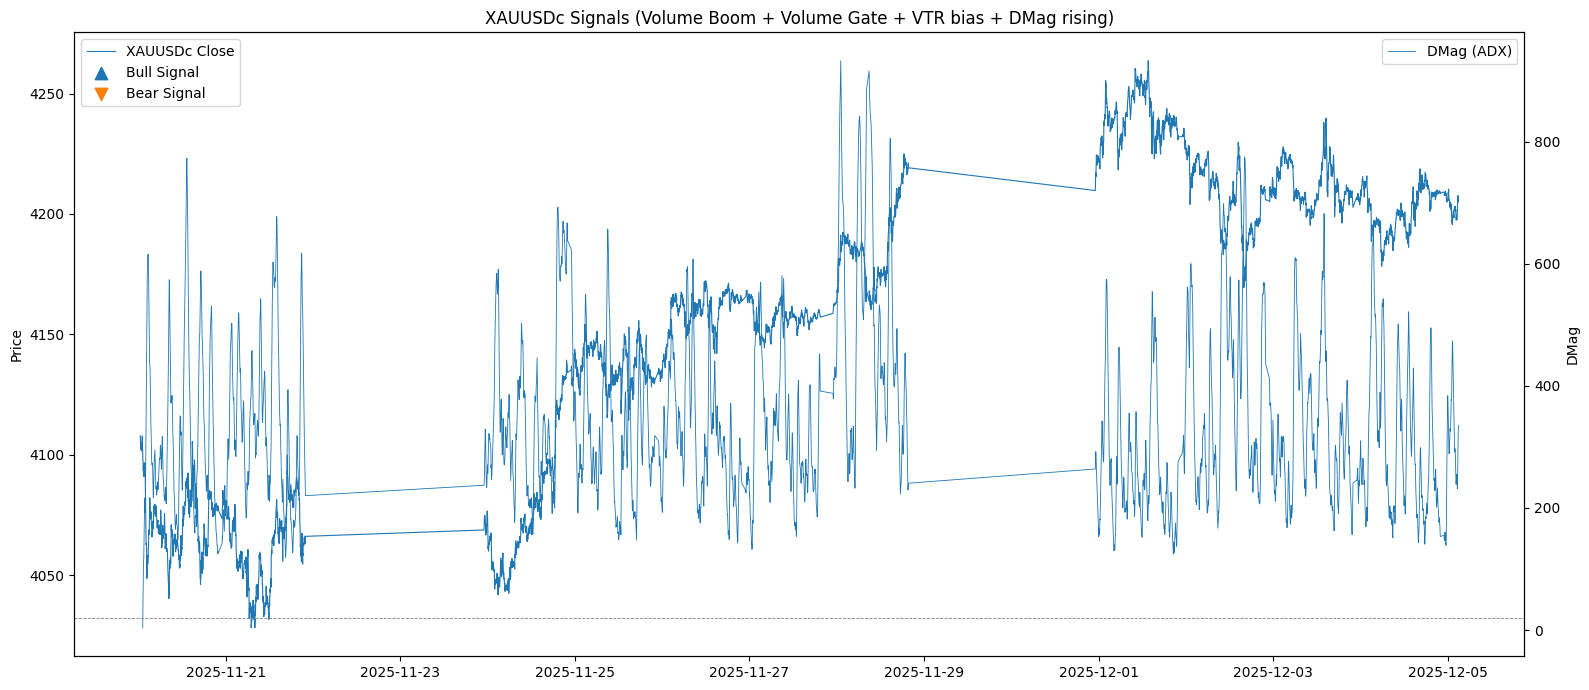

True

In [1]:
# mt5_xau_system.py
# Requirements: MetaTrader5, pandas, numpy, matplotlib
# pip install MetaTrader5 pandas numpy matplotlib

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime, timedelta

# -------------------------
# USER ADJUSTABLE PARAMETERS
# -------------------------
SYMBOL = "XAUUSDc"
TIMEFRAME = mt5.TIMEFRAME_M3     # change to TIMEFRAME_M1, M3, M5, H1 etc.
NUM_BARS = 5000                  # number of bars to fetch
VG_LOOKBACK = 50                 # lookback to compute Volume Gate baseline
VG_MULT = 1.0                    # multiply average volume to make Gate
VOL_BOOM_PRIORS = 10             # formula uses sum of previous 10 volumes
VTR_PARAMS = [(3,12), (10,1), (11,2)]   # (m,l) tuples for VTR1,VTR2,VTR3
DM_PERIOD = 14                   # Wilder smoothing period for DM/TR/ADX
DMAG_THRESH = 20                 # threshold for DMag (ADX)
PLOT_SAVEFILE = "xau_system_signals.png"
CSV_SAVEFILE = "xau_system_output.csv"
# -------------------------

# connect to MT5
if not mt5.initialize():
    print("MT5 initialize() failed, error:", mt5.last_error())
    sys.exit(1)

# ensure symbol available
symbol_info = mt5.symbol_info(SYMBOL)
if symbol_info is None:
    print(f"Symbol {SYMBOL} not found in MarketWatch. Attempting to add...")
    if not mt5.symbol_select(SYMBOL, True):
        print(f"Failed to select symbol {SYMBOL}.")
        mt5.shutdown()
        sys.exit(1)

# fetch bars
rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, NUM_BARS)
if rates is None or len(rates) == 0:
    print("Failed to get rates or zero bars.")
    mt5.shutdown()
    sys.exit(1)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
# columns: time, open, high, low, close, tick_volume, spread, real_volume (depends)
# use tick_volume as volume proxy
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df = df.set_index('time')

# convenience variables
df['close'] = df['close'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['volume'] = df['volume'].astype(float)

# -------------------------
# Indicators / helper funcs
# -------------------------

def true_range(high, low, close_prev):
    """
    True Range for a single bar: max(high-low, abs(high - close_prev), abs(low - close_prev))
    Operates on vectorized arrays.
    """
    tr1 = high - low
    tr2 = (high - close_prev).abs()
    tr3 = (low - close_prev).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

def wilder_smooth(series, period):
    """
    Wilder's smoothing for a series (first value is simple sum over period, after that:
    smoothed[i] = smoothed[i-1] - (smoothed[i-1] / period) + current[i]
    Returns a Series aligned with input (NaN for insufficient data).
    """
    out = pd.Series(index=series.index, dtype=float)
    first_idx = period - 1
    if len(series) < period:
        return out  # all NaN
    # initial value
    init_sum = series.iloc[:period].sum()
    out.iloc[first_idx] = init_sum
    # iterate forward
    for i in range(first_idx + 1, len(series)):
        prev = out.iloc[i - 1]
        cur = series.iloc[i]
        out.iloc[i] = prev - (prev / period) + cur
    return out

# compute True Range series
close_prev = df['close'].shift(1)
df['TR'] = true_range(df['high'], df['low'], close_prev)

# compute VTRs per image formula: VTR = m * (1/l) * sum_{i=0..l-1} TR_{t-i}
def compute_vtr(df_tr, m, l):
    # rolling sum of last l TR values including current
    s = df_tr.rolling(window=l, min_periods=1).sum()
    vtr = m * (s / l)
    return vtr

for idx, (m,l) in enumerate(VTR_PARAMS, start=1):
    df[f'VTR_{idx}'] = compute_vtr(df['TR'], m, l)

# Volume Gate (VG)
df['vg_baseline'] = df['volume'].rolling(VG_LOOKBACK, min_periods=1).mean() * VG_MULT
df['volume_gate'] = df['volume'] >= df['vg_baseline']

# Volume Boom: Vol(t) >= 2 * sum(volume_{t-1..t-10})
df['sum_prev_vol_10'] = df['volume'].shift(1).rolling(VOL_BOOM_PRIORS, min_periods=VOL_BOOM_PRIORS).sum()
df['volume_boom'] = df['volume'] >= (2 * df['sum_prev_vol_10'])

# VTR vs Price conditions (use close price)
# Bullish: all three VTRs > price
df['vtr_bull'] = (df['VTR_1'] > df['close']) & (df['VTR_2'] > df['close']) & (df['VTR_3'] > df['close'])
# Bearish: all three VTRs < price
df['vtr_bear'] = (df['VTR_1'] < df['close']) & (df['VTR_2'] < df['close']) & (df['VTR_3'] < df['close'])
# otherwise mixed (no trade)
df['vtr_no_trade'] = ~(df['vtr_bull'] | df['vtr_bear'])

# --------
# +DM / -DM per image logic (Wilder DM rules)
# --------
high_diff = df['high'] - df['high'].shift(1)
low_diff = df['low'].shift(1) - df['low']

# conditional assignment per image:
# +DM = max(high - high_prev, 0) if that > (low_prev - low) else 0
# -DM = max(low_prev - low, 0) if that > (high - high_prev) else 0
df['plus_dm_raw'] = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0.0)
df['minus_dm_raw'] = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0.0)

# smooth +DM, -DM, TR with Wilder's smoothing over DM_PERIOD
df['TR_smooth'] = wilder_smooth(df['TR'], DM_PERIOD)
df['plus_dm_smooth'] = wilder_smooth(df['plus_dm_raw'], DM_PERIOD)
df['minus_dm_smooth'] = wilder_smooth(df['minus_dm_raw'], DM_PERIOD)

# Avoid division by zero: where TR_smooth==0, set DI to NaN
df['plus_DI'] = 100.0 * (df['plus_dm_smooth'] / df['TR_smooth'])
df['minus_DI'] = 100.0 * (df['minus_dm_smooth'] / df['TR_smooth'])

# DX and DMag (ADX)
# DX = 100 * abs(plusDI - minusDI) / (plusDI + minusDI)
df['DX'] = 100.0 * ( (df['plus_DI'] - df['minus_DI']).abs() / (df['plus_DI'] + df['minus_DI']) )
df['DMag'] = wilder_smooth(df['DX'].fillna(0), DM_PERIOD)   # ADX-like

# Signal conditions
# DMag threshold and rising
df['dmag_cond'] = (df['DMag'] > DMAG_THRESH) & (df['DMag'] > df['DMag'].shift(1))

# combine synergy of DMag & VTR & volume rules
# bull signal
df['signal_bull'] = df['volume_boom'] & df['volume_gate'] & df['vtr_bull'] & df['dmag_cond']
# bear signal
df['signal_bear'] = df['volume_boom'] & df['volume_gate'] & df['vtr_bear'] & df['dmag_cond']

# for plotting convenience
df['signal'] = 0
df.loc[df['signal_bull'], 'signal'] = 1
df.loc[df['signal_bear'], 'signal'] = -1

# save CSV for offline inspection
df_out = df[['open','high','low','close','volume','vg_baseline','volume_gate','sum_prev_vol_10','volume_boom',
             'TR','VTR_1','VTR_2','VTR_3','vtr_bull','vtr_bear','plus_dm_raw','minus_dm_raw',
             'plus_dm_smooth','minus_dm_smooth','TR_smooth','plus_DI','minus_DI','DX','DMag','dmag_cond','signal']]
df_out.to_csv(CSV_SAVEFILE, index=True)
print(f"Saved output to {CSV_SAVEFILE}")

# -------------------------
# PLOTTING
# -------------------------
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16,7))
ax.plot(df.index, df['close'], label=f'{SYMBOL} Close', linewidth=0.8)

# buy dots (green up triangle) and sell dots (red down triangle)
buy_idx = df.index[df['signal'] == 1]
sell_idx = df.index[df['signal'] == -1]
ax.scatter(buy_idx, df.loc[buy_idx, 'close'], marker='^', s=80, label='Bull Signal', zorder=5)
ax.scatter(sell_idx, df.loc[sell_idx, 'close'], marker='v', s=80, label='Bear Signal', zorder=5)

# optionally plot DMag in a separate axis
ax2 = ax.twinx()
ax2.plot(df.index, df['DMag'], label='DMag (ADX)', linewidth=0.6)
ax2.axhline(DMAG_THRESH, color='gray', linestyle='--', linewidth=0.6)

ax.set_title(f'{SYMBOL} Signals (Volume Boom + Volume Gate + VTR bias + DMag rising)')
ax.set_ylabel('Price')
ax2.set_ylabel('DMag')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(PLOT_SAVEFILE, dpi=150)
print(f"Saved plot to {PLOT_SAVEFILE}")
plt.show()

# cleanup
mt5.shutdown()


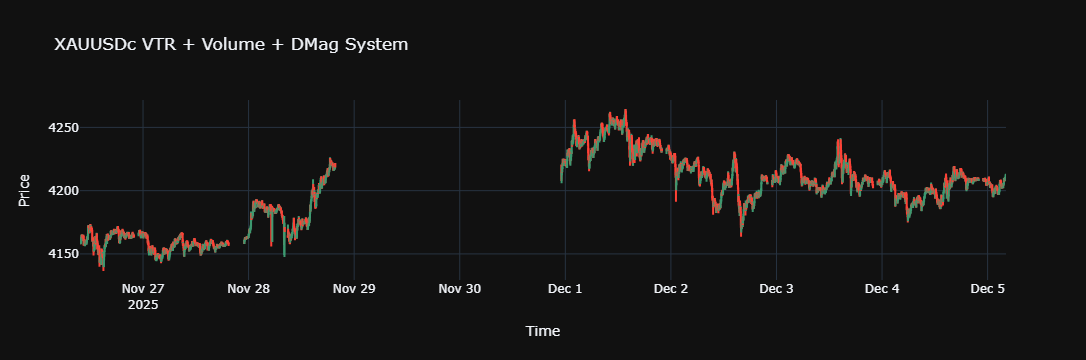

True

In [3]:
# ===============================================
# XAUUSDc SYSTEM WITH VTR + VOLUME + DMAG (ADX)
# FULL MT5 DATA FETCH + PLOTLY CANDLE + SIGNALS
# ===============================================

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import sys

# =========================
# USER PARAMETERS
# =========================
SYMBOL = "XAUUSDc"
TIMEFRAME = mt5.TIMEFRAME_M3
NUM_BARS = 3000

VG_LOOKBACK = 50
VG_MULT = 1.0

VTR_PARAMS = [(3,12), (10,1), (11,2)]

VOL_BOOM_LOOKBACK = 10
VOL_BOOM_MULT = 2

DM_PERIOD = 14
DMAG_THRESHOLD = 20

# =========================
# MT5 INITIALIZATION
# =========================
if not mt5.initialize():
    print("MT5 initialization failed")
    sys.exit()

rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, NUM_BARS)
if rates is None:
    print("Data fetch failed")
    mt5.shutdown()
    sys.exit()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

df.rename(columns={'tick_volume': 'volume'}, inplace=True)

# =========================
# TRUE RANGE (TR)
# =========================
close_prev = df['close'].shift(1)

tr1 = df['high'] - df['low']
tr2 = (df['high'] - close_prev).abs()
tr3 = (df['low'] - close_prev).abs()

df['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

# =========================
# VTR CALCULATIONS
# =========================
def compute_vtr(series, m, l):
    return m * (series.rolling(l).sum() / l)

df['VTR_1'] = compute_vtr(df['TR'], *VTR_PARAMS[0])
df['VTR_2'] = compute_vtr(df['TR'], *VTR_PARAMS[1])
df['VTR_3'] = compute_vtr(df['TR'], *VTR_PARAMS[2])

# =========================
# VTR PRICE BIAS
# =========================
df['VTR_BULL'] = (df['VTR_1'] > df['close']) & (df['VTR_2'] > df['close']) & (df['VTR_3'] > df['close'])
df['VTR_BEAR'] = (df['VTR_1'] < df['close']) & (df['VTR_2'] < df['close']) & (df['VTR_3'] < df['close'])

# =========================
# VOLUME GATE
# =========================
df['VG'] = df['volume'].rolling(VG_LOOKBACK).mean() * VG_MULT
df['VOLUME_GATE'] = df['volume'] >= df['VG']

# =========================
# VOLUME BOOM
# =========================
df['VOL_SUM_PREV'] = df['volume'].shift(1).rolling(VOL_BOOM_LOOKBACK).sum()
df['VOLUME_BOOM'] = df['volume'] >= (VOL_BOOM_MULT * df['VOL_SUM_PREV'])

# =========================
# +DM / -DM (WILDER)
# =========================
up = df['high'] - df['high'].shift(1)
down = df['low'].shift(1) - df['low']

df['+DM'] = np.where((up > down) & (up > 0), up, 0)
df['-DM'] = np.where((down > up) & (down > 0), down, 0)

# =========================
# WILDER SMOOTHING FUNCTION
# =========================
def wilder(series, period):
    out = np.zeros(len(series))
    out[:period] = np.nan
    out[period] = series.iloc[:period].sum()
    for i in range(period+1, len(series)):
        out[i] = out[i-1] - (out[i-1] / period) + series.iloc[i]
    return pd.Series(out, index=series.index)

df['TR_S'] = wilder(df['TR'], DM_PERIOD)
df['+DM_S'] = wilder(df['+DM'], DM_PERIOD)
df['-DM_S'] = wilder(df['-DM'], DM_PERIOD)

# =========================
# DI, DX, ADX (DMag)
# =========================
df['+DI'] = 100 * (df['+DM_S'] / df['TR_S'])
df['-DI'] = 100 * (df['-DM_S'] / df['TR_S'])

df['DX'] = 100 * (np.abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI']))

# ADX (DMag)
df['DMag'] = df['DX'].rolling(DM_PERIOD).mean()

# =========================
# FINAL SIGNAL CONDITIONS
# =========================
df['DMAG_FILTER'] = (df['DMag'] > DMAG_THRESHOLD) & (df['DMag'] > df['DMag'].shift(1))

df['BULL_SIGNAL'] = df['VTR_BULL'] & df['VOLUME_GATE'] & df['VOLUME_BOOM'] & df['DMAG_FILTER']
df['BEAR_SIGNAL'] = df['VTR_BEAR'] & df['VOLUME_GATE'] & df['VOLUME_BOOM'] & df['DMAG_FILTER']

# =========================
# SIGNAL ANCHOR PRICES
# =========================
bull_x = df.index[df['BULL_SIGNAL']]
bull_y = df.loc[df['BULL_SIGNAL'], 'low'] - 0.5

bear_x = df.index[df['BEAR_SIGNAL']]
bear_y = df.loc[df['BEAR_SIGNAL'], 'high'] + 0.5

# =========================
# PLOTLY CANDLESTICK
# =========================
fig = go.Figure()

fig.add_candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name="XAUUSDc"
)

# =========================
# SIGNAL MARKERS
# =========================
fig.add_scatter(
    x=bull_x,
    y=bull_y,
    mode='markers',
    marker=dict(size=10, symbol='triangle-up'),
    name="BULL SIGNAL"
)

fig.add_scatter(
    x=bear_x,
    y=bear_y,
    mode='markers',
    marker=dict(size=10, symbol='triangle-down'),
    name="BEAR SIGNAL"
)

fig.update_layout(
    title="XAUUSDc VTR + Volume + DMag System",
    xaxis_title="Time",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False,
    template="plotly_dark"
)

fig.show()

mt5.shutdown()


In [ ]:
VTR

C:\Users\User\AppData\Local\Temp\ipykernel_9376\935381340.py:188: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\User\AppData\Local\Temp\ipykernel_9376\935381340.py:194: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



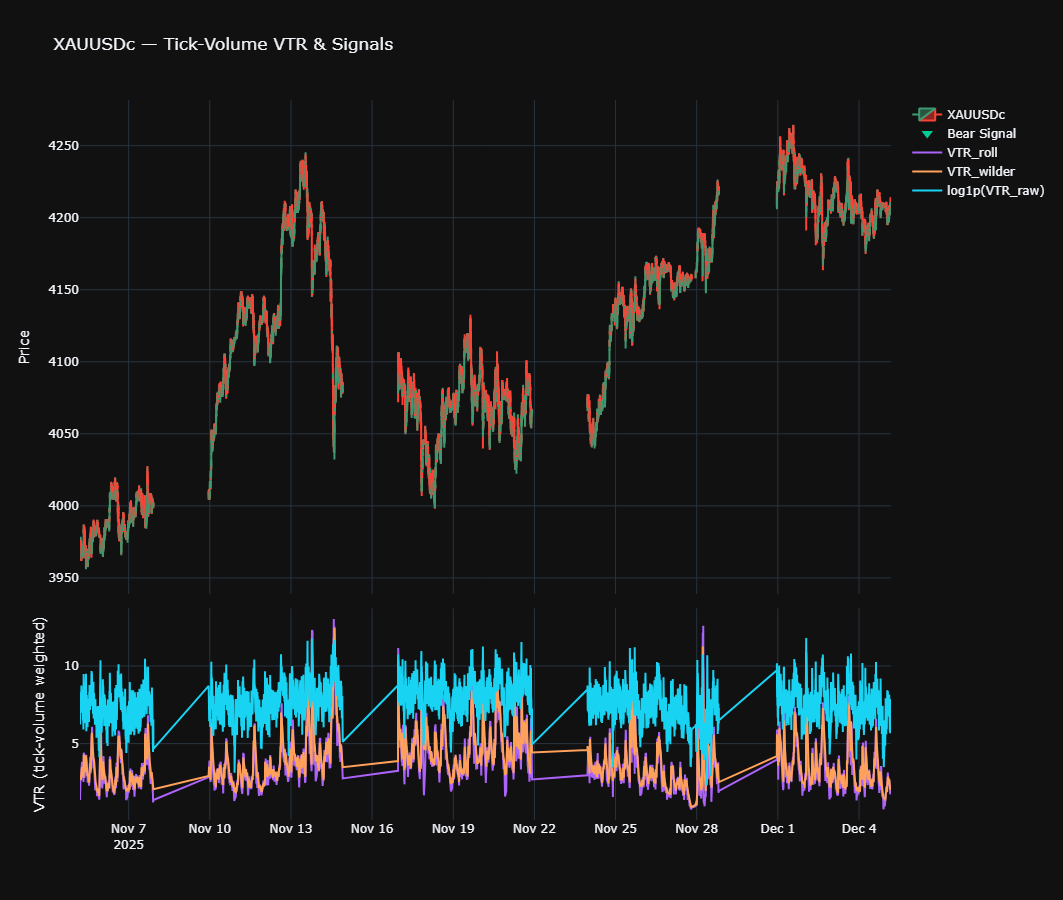

Wrote xau_vtr_tickvolume_output.csv


True

In [6]:
"""
xau_vtr_tickvolume.py

Fetch XAUUSDc bars from MT5, compute tick-volume-weighted TR, ATR, and VTR variants:
 - ATR_tv      = Wilder-style ATR weighted by tick volume
 - VTR_raw     = TR_t * tick_volume_t
 - VTR_roll    = rolling window weighted average: sum(TR*Vol)/sum(Vol)
 - VTR_wilder  = Wilder-style recursive smoothing on (TR*Vol)/smoothed Vol

Plot candlestick chart with signals and VTR pane using Plotly.

Requirements:
pip install MetaTrader5 pandas numpy plotly
Run MT5 desktop with XAUUSDc symbol visible.
"""

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys

# ----------------------------
# USER PARAMETERS
# ----------------------------
SYMBOL = "XAUUSDc"
TIMEFRAME = mt5.TIMEFRAME_M3
NUM_BARS = 10000

VG_LOOKBACK = 50
VG_MULT = 1.0

VOL_BOOM_LOOKBACK = 10
VOL_BOOM_MULT = 2

VTR_ROLL_WINDOW = 14
VTR_WILDER_PERIOD = 14

DM_PERIOD = 14
DMAG_THRESHOLD = 20

REQUIRE_VTR_FILTER = True
VTR_FILTER_MULT = 1.0

# ----------------------------
# MT5 fetch
# ----------------------------
if not mt5.initialize():
    print("MT5 initialization failed:", mt5.last_error())
    sys.exit(1)

rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, NUM_BARS)
if rates is None or len(rates) == 0:
    print("Failed to fetch data for", SYMBOL)
    mt5.shutdown()
    sys.exit(1)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# Use tick_volume only
df['volume'] = df['tick_volume'].astype(float)

for c in ['open','high','low','close','volume']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# ----------------------------
# Tick-volume-weighted TR and ATR
# ----------------------------
df['close_prev'] = df['close'].shift(1)
df['TR'] = pd.concat([
    (df['high'] - df['low']),
    (df['high'] - df['close_prev']).abs(),
    (df['low'] - df['close_prev']).abs()
], axis=1).max(axis=1)

def wilder_tv(series, volume, period):
    """
    Wilder smoothing weighted by tick volume.
    series: TR series
    volume: tick_volume series
    """
    out = pd.Series(index=series.index, dtype=float)
    if len(series) < period:
        return out
    # seed: volume-weighted mean
    seed = (series.iloc[:period] * volume.iloc[:period]).sum() / volume.iloc[:period].sum()
    out.iloc[period-1] = seed
    for i in range(period, len(series)):
        prev = out.iloc[i-1]
        cur = series.iloc[i]
        vol = volume.iloc[i]
        out.iloc[i] = prev - (prev * vol / volume.iloc[i-period+1:i+1].sum()) + (cur * vol / volume.iloc[i-period+1:i+1].sum())
    return out

df['ATR_tv'] = wilder_tv(df['TR'], df['volume'], VTR_WILDER_PERIOD)

# ----------------------------
# VTR variants (tick-volume-based)
# ----------------------------
df['VTR_raw'] = df['TR'] * df['volume']

# Rolling weighted VTR
def rolling_weighted_vtr(tr_series, vol_series, window):
    num = (tr_series * vol_series).rolling(window=window, min_periods=1).sum()
    den = vol_series.rolling(window=window, min_periods=1).sum()
    return num / den

df['VTR_roll'] = rolling_weighted_vtr(df['TR'], df['volume'], VTR_ROLL_WINDOW)

# Wilder recursive VTR
def wilder_recursive(series, period):
    out = pd.Series(index=series.index, dtype=float)
    if len(series) < period:
        return out
    seed = series.iloc[:period].sum()
    out.iloc[period-1] = seed
    for i in range(period, len(series)):
        out.iloc[i] = out.iloc[i-1] - (out.iloc[i-1]/period) + series.iloc[i]
    return out

num_smooth = wilder_recursive(df['TR']*df['volume'], VTR_WILDER_PERIOD)
vol_smooth = wilder_recursive(df['volume'], VTR_WILDER_PERIOD)
df['VTR_wilder'] = np.where(vol_smooth > 0, num_smooth / vol_smooth, np.nan)

df['VTR_roll_mean'] = df['VTR_roll'].rolling(window=VTR_ROLL_WINDOW, min_periods=1).mean()
df['VTR_filter_pass'] = df['VTR_roll'] >= (df['VTR_roll_mean'] * VTR_FILTER_MULT)

# ----------------------------
# Volume Gate / Boom
# ----------------------------
df['VG'] = df['volume'].rolling(VG_LOOKBACK, min_periods=1).mean() * VG_MULT
df['VOLUME_GATE'] = df['volume'] >= df['VG']

df['VOL_SUM_PREV'] = df['volume'].shift(1).rolling(VOL_BOOM_LOOKBACK, min_periods=VOL_BOOM_LOOKBACK).sum()
df['VOLUME_BOOM'] = df['volume'] >= (VOL_BOOM_MULT * df['VOL_SUM_PREV'])

# ----------------------------
# Directional Movement (tick-volume-weighted)
# ----------------------------
df['high_diff'] = df['high'] - df['high'].shift(1)
df['low_diff'] = df['low'].shift(1) - df['low']

df['plus_dm_raw'] = np.where((df['high_diff'] > df['low_diff']) & (df['high_diff'] > 0), df['high_diff'], 0.0)
df['minus_dm_raw'] = np.where((df['low_diff'] > df['high_diff']) & (df['low_diff'] > 0), df['low_diff'], 0.0)

df['TR_smooth'] = wilder_recursive(df['TR']*df['volume'], DM_PERIOD)
df['plus_dm_smooth'] = wilder_recursive(df['plus_dm_raw']*df['volume'], DM_PERIOD)
df['minus_dm_smooth'] = wilder_recursive(df['minus_dm_raw']*df['volume'], DM_PERIOD)

df['plus_DI'] = 100.0 * (df['plus_dm_smooth'] / df['TR_smooth'])
df['minus_DI'] = 100.0 * (df['minus_dm_smooth'] / df['TR_smooth'])
df['DX'] = 100.0 * ((df['plus_DI'] - df['minus_DI']).abs() / (df['plus_DI'] + df['minus_DI']))
df['DMag'] = df['DX'].rolling(DM_PERIOD, min_periods=1).mean()
df['DMag_filter'] = (df['DMag'] > DMAG_THRESHOLD) & (df['DMag'] > df['DMag'].shift(1))

# ----------------------------
# Final Signals (tick-volume-based)
# ----------------------------
base_condition = df['VOLUME_GATE'] & df['VOLUME_BOOM'] & df['DMag_filter']
if REQUIRE_VTR_FILTER:
    base_condition &= df['VTR_filter_pass']

df['close_mean_20'] = df['close'].rolling(20, min_periods=1).mean()
bull_bias = df['close'] > df['close_mean_20']
bear_bias = df['close'] < df['close_mean_20']

df['BULL_SIGNAL'] = base_condition & bull_bias
df['BEAR_SIGNAL'] = base_condition & bear_bias

# ----------------------------
# Plotting
# ----------------------------
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.02,
                    row_heights=[0.7, 0.3],
                    specs=[[{"type":"candlestick"}],
                           [{"type":"scatter"}]])

fig.add_trace(go.Candlestick(
    x=df.index, open=df['open'], high=df['high'], low=df['low'], close=df['close'], name="XAUUSDc"
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index[df['BULL_SIGNAL']],
    y=df.loc[df['BULL_SIGNAL'], 'low'] - (df['ATR_tv'].fillna(method='bfill') * 0.2),
    mode='markers', marker=dict(symbol='triangle-up', size=10), name='Bull Signal'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=df.index[df['BEAR_SIGNAL']],
    y=df.loc[df['BEAR_SIGNAL'], 'high'] + (df['ATR_tv'].fillna(method='bfill') * 0.2),
    mode='markers', marker=dict(symbol='triangle-down', size=10), name='Bear Signal'
), row=1, col=1)

fig.add_trace(go.Scatter(x=df.index, y=df['VTR_roll'], mode='lines', name='VTR_roll'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=df['VTR_wilder'], mode='lines', name='VTR_wilder'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.index, y=np.log1p(df['VTR_raw'].fillna(0)), mode='lines', name='log1p(VTR_raw)'), row=2, col=1)

fig.update_layout(title=f"{SYMBOL} — Tick-Volume VTR & Signals", xaxis_rangeslider_visible=False, template="plotly_dark", height=900)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_yaxes(title_text="VTR (tick-volume weighted)", row=2, col=1)

fig.show()

# ----------------------------
# Save CSV
# ----------------------------
OUT_CSV = "xau_vtr_tickvolume_output.csv"
cols_to_save = [
    'open','high','low','close','volume','TR','ATR_tv',
    'VTR_raw','VTR_roll','VTR_wilder','VTR_roll_mean',
    'VG','VOLUME_GATE','VOL_SUM_PREV','VOLUME_BOOM',
    'plus_dm_raw','minus_dm_raw','plus_dm_smooth','minus_dm_smooth','TR_smooth',
    'plus_DI','minus_DI','DX','DMag','DMag_filter',
    'VTR_filter_pass','BULL_SIGNAL','BEAR_SIGNAL'
]
df[cols_to_save].to_csv(OUT_CSV)
print(f"Wrote {OUT_CSV}")

mt5.shutdown()


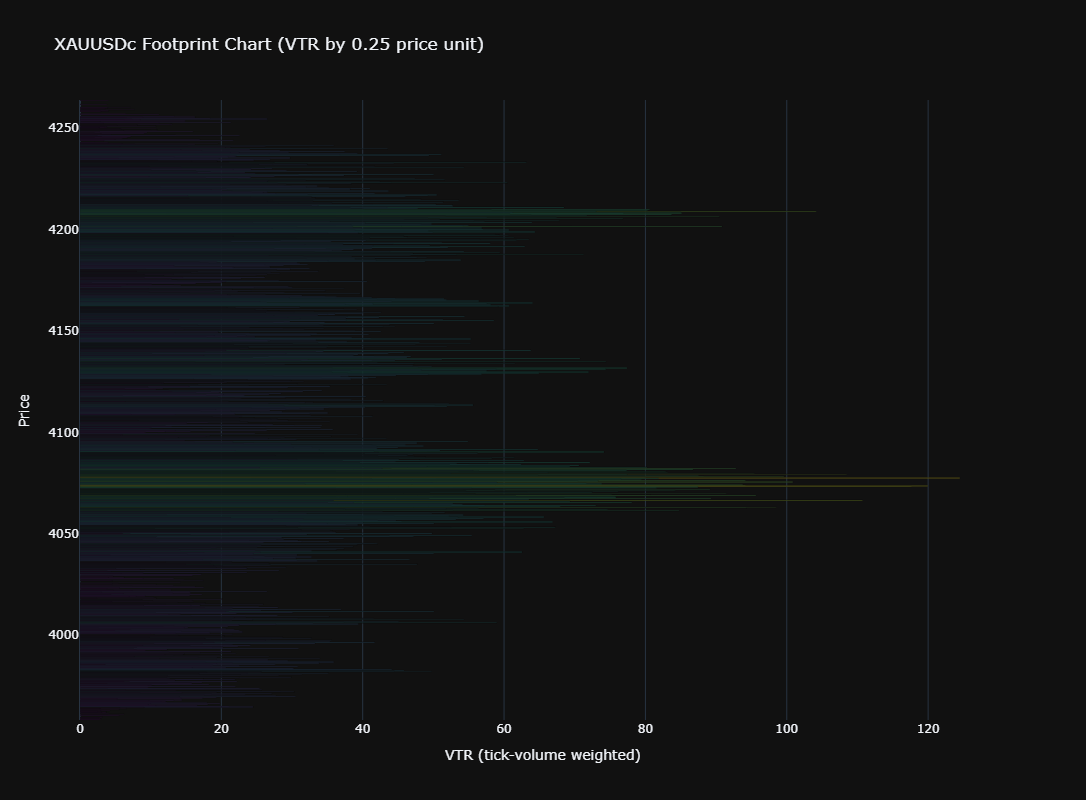

In [7]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ----------------------------
# PARAMETERS
# ----------------------------
PRICE_BIN = 0.25   # footprint price precision
VTR_COLUMN = 'VTR_roll'  # which VTR to aggregate for footprint

# ----------------------------
# Generate footprint (VTR by price bin)
# ----------------------------
# Round price to nearest bin
df['price_bin'] = (df['close'] / PRICE_BIN).round() * PRICE_BIN

# Aggregate VTR per bin
footprint = df.groupby('price_bin')[VTR_COLUMN].sum().reset_index()
footprint = footprint.sort_values('price_bin', ascending=False)

# ----------------------------
# Create footprint bar chart
# ----------------------------
fig = go.Figure()

fig.add_trace(go.Bar(
    x=footprint[VTR_COLUMN],
    y=footprint['price_bin'],
    orientation='h',
    marker=dict(color=footprint[VTR_COLUMN], colorscale='Viridis'),
    name='VTR per price bin'
))

fig.update_layout(
    title=f"{SYMBOL} Footprint Chart (VTR by {PRICE_BIN} price unit)",
    xaxis_title='VTR (tick-volume weighted)',
    yaxis_title='Price',
    template='plotly_dark',
    height=800
)

fig.show()


In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import sys

# ----------------------------
# USER PARAMETERS
# ----------------------------
SYMBOL = "XAUUSDc"
TIMEFRAME = mt5.TIMEFRAME_M3
NUM_BARS = 500
PRICE_BIN = 0.25  # footprint bin size
VTR_WILDER_PERIOD = 14

# ----------------------------
# MT5 fetch
# ----------------------------
if not mt5.initialize():
    print("MT5 initialization failed:", mt5.last_error())
    sys.exit(1)

rates = mt5.copy_rates_from_pos(SYMBOL, TIMEFRAME, 0, NUM_BARS)
if rates is None or len(rates) == 0:
    print("Failed to fetch data for", SYMBOL)
    mt5.shutdown()
    sys.exit(1)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df['volume'] = df['tick_volume'].astype(float)

for c in ['open','high','low','close','volume']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# ----------------------------
# Compute TR and VTR
# ----------------------------
df['close_prev'] = df['close'].shift(1)
df['TR'] = pd.concat([
    (df['high'] - df['low']),
    (df['high'] - df['close_prev']).abs(),
    (df['low'] - df['close_prev']).abs()
], axis=1).max(axis=1)

def wilder_recursive(series, period):
    out = pd.Series(index=series.index, dtype=float)
    if len(series) < period:
        return out
    seed = series.iloc[:period].mean()
    out.iloc[period-1] = seed
    for i in range(period, len(series)):
        out.iloc[i] = out.iloc[i-1] - (out.iloc[i-1]/period) + series.iloc[i]
    return out

df['VTR'] = wilder_recursive(df['TR']*df['volume'], VTR_WILDER_PERIOD)

# ----------------------------
# Footprint bins (price levels)
# ----------------------------
def compute_footprint(candle):
    """
    Returns a dict: price_bin -> accumulated VTR
    """
    low = candle['low']
    high = candle['high']
    vtr = candle['VTR']
    
    bins = np.arange(np.floor(low / PRICE_BIN) * PRICE_BIN,
                     np.ceil(high / PRICE_BIN) * PRICE_BIN + PRICE_BIN,
                     PRICE_BIN)
    bin_vtr = dict.fromkeys(bins, 0.0)
    
    # distribute VTR proportionally across price bins
    if high > low:
        for b in bins:
            # proportion of bin within candle range
            prop = min(high, b + PRICE_BIN) - max(low, b)
            prop = max(prop, 0)
            bin_vtr[b] = prop / (high - low) * vtr
    else:
        bin_vtr[low] = vtr
    return bin_vtr

footprint_data = []
for idx, row in df.iterrows():
    footprint_data.append(compute_footprint(row))

# ----------------------------
# Plot footprint candles using rectangles
# ----------------------------
fig = go.Figure()

for i, row in enumerate(df.itertuples()):
    bins = footprint_data[i]
    for price, vtr_val in bins.items():
        if vtr_val <= 0: 
            continue
        color = 'green' if row.close >= row.open else 'red'
        fig.add_shape(
            type="rect",
            x0=row.Index - pd.Timedelta(minutes=1),  # narrow candle
            x1=row.Index + pd.Timedelta(minutes=1),
            y0=price,
            y1=price + PRICE_BIN,
            line=dict(width=0),
            fillcolor=color,
            opacity=min(0.6, 0.2 + vtr_val / df['VTR'].max())
        )

# Candlestick overlay for reference
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'], high=df['high'], low=df['low'], close=df['close'],
    name='Price'
))

fig.update_layout(
    title=f"{SYMBOL} Footprint Candles (VTR weighted, {PRICE_BIN} price bin)",
    xaxis_rangeslider_visible=False,
    template="plotly_dark",
    height=900
)

fig.show()
mt5.shutdown()
